## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [53]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table

from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-04-14 13:42:39.121578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-14 13:42:39.126007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-14 13:42:39.128823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Load input datasets

In [54]:
def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table




# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'parkets/benign/benign_2312_anonymized_HTML.parquet', 
    'parkets/benign/umbrella_benign_FINISHED_HTML.parquet'
        
]
malicious_dataset_filenames = [
    'parkets/malware_2406_strict_HTML.parquet'
]

# lex-dga-830k-pick.parquet LABEL je jmeno rodiny
#  'parkets/malware_2406_strict_HTML.parquet'


# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "malware"
# #############################################################

# print labels from malicious datasets


# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
#df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)





In [55]:
subsample = 0.6 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample, random_state=42)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)


    
print(f"Total features: {len(df.columns)}")
print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

Total features: 264
Total samples: 550280
Benign count: 816324
Malicious count: 100809


# Data preprocessing

In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "scalers/phishing_deepnn_scaler.joblib")

pd.set_option('display.max_columns', None)
features

,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,dns_zone_digit_count,dns_zone_len,dns_zone_entropy,dns_resolved_record_types,dns_dnssec_score,dns_ttl_avg,dns_ttl_stdev,dns_ttl_low,dns_ttl_mid,dns_ttl_distinct_count,dns_soa_primary_ns_level,dns_soa_primary_ns_digit_count,dns_soa_primary_ns_len,dns_soa_primary_ns_entropy,dns_soa_email_level,dns_soa_email_digit_count,dns_soa_email_len,dns_soa_email_entropy,dns_soa_refresh,dns_soa_retry,dns_soa_expire,dns_soa_min_ttl,dns_domain_name_in_mx,dns_mx_avg_len,dns_mx_avg_entropy,dns_txt_avg_len,dns_txt_avg_entropy,dns_txt_external_verification_score,dns_txt_spf_exists,dns_txt_dkim_exists,dns_txt_dmarc_exists,ip_count,ip_mean_average_rtt,ip_v4_ratio,ip_a_aaaa_to_all_ratio,ip_entropy,ip_as_address_entropy,ip_asn_entropy,ip_distinct_as_count,tls_has_tls,tls_chain_len,tls_is_self_signed,tls_root_authority_hash,tls_leaf_authority_hash,tls_negotiated_version_id,tls_negotiated_cipher_id,tls_root_cert_validity_len,tls_leaf_cert_validity_len,tls_broken_chain,tls_expired_chain,tls_total_extension_count,tls_critical_extensions,tls_with_policies_crt_count,tls_percentage_crt_with_policies,tls_x509_anypolicy_crt_count,tls_iso_policy_crt_count,tls_joint_isoitu_policy_crt_count,tls_subject_count,tls_server_auth_crt_count,tls_client_auth_crt_count,tls_CA_certs_in_chain_ratio,tls_unique_SLD_count,tls_common_name_count,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_benign_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_tld_hash,lex_sld_len,lex_sld_norm_entropy,lex_sld_digit_count,lex_sld_digit_ratio,lex_sld_phishing_keyword_count,lex_sld_vowel_count,lex_sld_vowel_ratio,lex_sld_consonant_count,lex_sld_consonant_ratio,lex_sld_non_alphanum_count,lex_sld_non_alphanum_ratio,lex_sld_hex_count,lex_sld_hex_ratio,lex_sub_count,lex_stld_unique_char_count,lex_begins_with_digit,lex_www_flag,lex_sub_max_consonant_len,lex_sub_norm_entropy,lex_sub_digit_count,lex_sub_digit_ratio,lex_sub_vowel_count,lex_sub_vowel_ratio,lex_sub_consonant_count,lex_sub_consonant_ratio,lex_sub_non_alphanum_count,lex_sub_non_alphanum_ratio,lex_sub_hex_count,lex_sub_hex_ratio,lex_phishing_bigram_matches,lex_phishing_trigram_matches,lex_phishing_tetragram_matches,lex_phishing_pentagram_matches,lex_malware_bigram_matches,lex_malware_trigram_matches,lex_malware_tetragram_matches,lex_dga_bigram_matches,lex_dga_trigram_matches,lex_dga_tetragram_matches,lex_avg_part_len,lex_stdev_part_lens,lex_longest_part_len,lex_short_part_count,lex_medium_part_count,lex_long_part_count,lex_superlong_part_count,lex_shortest_sub_len,lex_ipv4_in_domain,lex_has_trusted_suffix,lex_has_wellknown_suffix,lex_has_cdn_suffix,lex_has_vps_suffix,lex_has_img_suffix,lex_suffix_score,geo_countries_count,geo_continents_count,geo_malic_host_country,geo_lat_stdev,geo_lon_stdev,geo_mean_lat,geo_mean_lon,geo_min_lat,geo_max_lat,geo_min_lon,geo_max_lon,geo_lat_range,geo_lon_range,geo_centroid_lat,geo_centroid_lon,geo_estimated_area,geo_continent_hash,geo_countries_hash,rdap_registration_period,rdap_domain_age,rdap_time_from_last_change,rdap_domain_active_time,rdap_has_dnssec,rdap_registrar_name_len,rdap_registrar_name_entropy,rdap_registrar_name_hash,rdap_registrant_name_len,rdap_registrant_name_entropy,rdap_admin_name_len,rdap_admin_name_entropy,rdap_admin_email_len,rdap_admin_email_entropy,rdap_ip_v4_count,rdap_ip_v6_count,rdap_ip_shortest_v4_prefix_len,rdap_ip_longest_v4_prefix_len,rdap_ip_shortest_v6_prefix_len,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_entropy,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_entropy,html_num_of_tags,html_num_of_paragraphs,html_num_of_divs,html_num_of_titles,html_num_of_external_js,html_num_of_links,html_num_of_scripts,html_num_of_scripts_async,html_num_of_scripts_type,html_num_of_anchors,html_num_of_anchors_to_hash,html_num_of_anchors_to_https,html_num_of_anchors_to_com,html_num_of_inputs,html

# Train-test split

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# print number of features
print(X_train.shape[1])

263


# Define the NN model

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def build_feedforward_net(feature_size):
    # Input layer
    inputs = Input(shape=(feature_size,))
    
    # First hidden layer
    x = Dense(1024, activation=None)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second hidden layer
    x = Dense(512, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third hidden layer
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Fourth hidden layer
    x = Dense(128, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Build and return the model
    model = Model(inputs=inputs, outputs=outputs, name="simple_feedforward_NN")
    return model

# Instantiate the model
feature_size = 263  # Adjust based on your data
model = build_feedforward_net(feature_size)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0023),
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall', 'AUC']
)

# Show model architecture
model.summary()


Model: "simple_feedforward_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 263)]             0         
                                                                 
 dense_24 (Dense)            (None, 1024)              270336    
                                                                 
 batch_normalization_18 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_19 (Ba  (None, 512)               2048      
 tchNormalization)                           

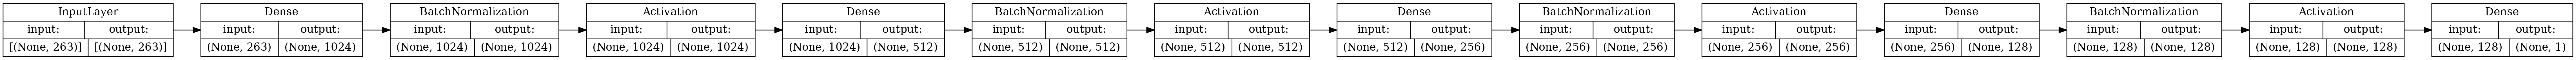

In [66]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 3,
}

from tensorflow.keras.utils import plot_model

# Save the model visualization
plot_model(
    model,
    to_file='compact_graph.png',
    show_shapes=True,
    show_layer_names=False,
    dpi=196,  # Adjust DPI for higher/lower resolution
    expand_nested=False,  # Makes complex models more compact
    rankdir='LR'  # Use 'LR' for a horizontal layout, 'TB' for vertical
)

# Display the image
from IPython.display import Image
Image(filename='compact_graph.png')



In [ ]:
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculate class weights
class_weights = {0: 1.0, 1: 0.9} 

history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=50,
    validation_data=(X_test, Y_test),  # Provide validation data
    class_weight=class_weights,  # Apply class weights here
    callbacks=[early_stopping]  # Add early stopping callback
)


2025-04-14 13:43:09.940623: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 926231296 exceeds 10% of free system memory.
2025-04-14 13:43:10.843667: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 926231296 exceeds 10% of free system memory.


Epoch 1/50
853/860 [============================>.] - ETA: 0s - loss: 0.0922 - precision: 0.8539 - recall: 0.8066 - auc: 0.9840

2025-04-14 13:43:17.418837: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 231557824 exceeds 10% of free system memory.
2025-04-14 13:43:17.617275: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 231557824 exceeds 10% of free system memory.


860/860 [==============================] - 7s 5ms/step - loss: 0.0921 - precision: 0.8541 - recall: 0.8070 - auc: 0.9841 - val_loss: 0.0712 - val_precision: 0.8929 - val_recall: 0.8402 - val_auc: 0.9894
Epoch 2/50
860/860 [==============================] - 3s 4ms/step - loss: 0.0675 - precision: 0.8894 - recall: 0.8573 - auc: 0.9912 - val_loss: 0.0631 - val_precision: 0.8970 - val_recall: 0.8730 - val_auc: 0.9916
Epoch 3/50
860/860 [==============================] - 4s 4ms/step - loss: 0.0599 - precision: 0.9040 - recall: 0.8747 - auc: 0.9930 - val_loss: 0.0640 - val_precision: 0.8577 - val_recall: 0.9161 - val_auc: 0.9924
Epoch 4/50
860/860 [==============================] - 3s 4ms/step - loss: 0.0548 - precision: 0.9104 - recall: 0.8845 - auc: 0.9941 - val_loss: 0.0576 - val_precision: 0.9244 - val_recall: 0.8674 - val_auc: 0.9924
Epoch 5/50
860/860 [==============================] - 3s 4ms/step - loss: 0.0512 - precision: 0.9166 - recall: 0.8926 - auc: 0.9948 - val_loss: 0.0538 - va

In [61]:
print(history.history.keys())


dict_keys(['loss', 'precision', 'recall', 'auc', 'val_loss', 'val_precision', 'val_recall', 'val_auc'])


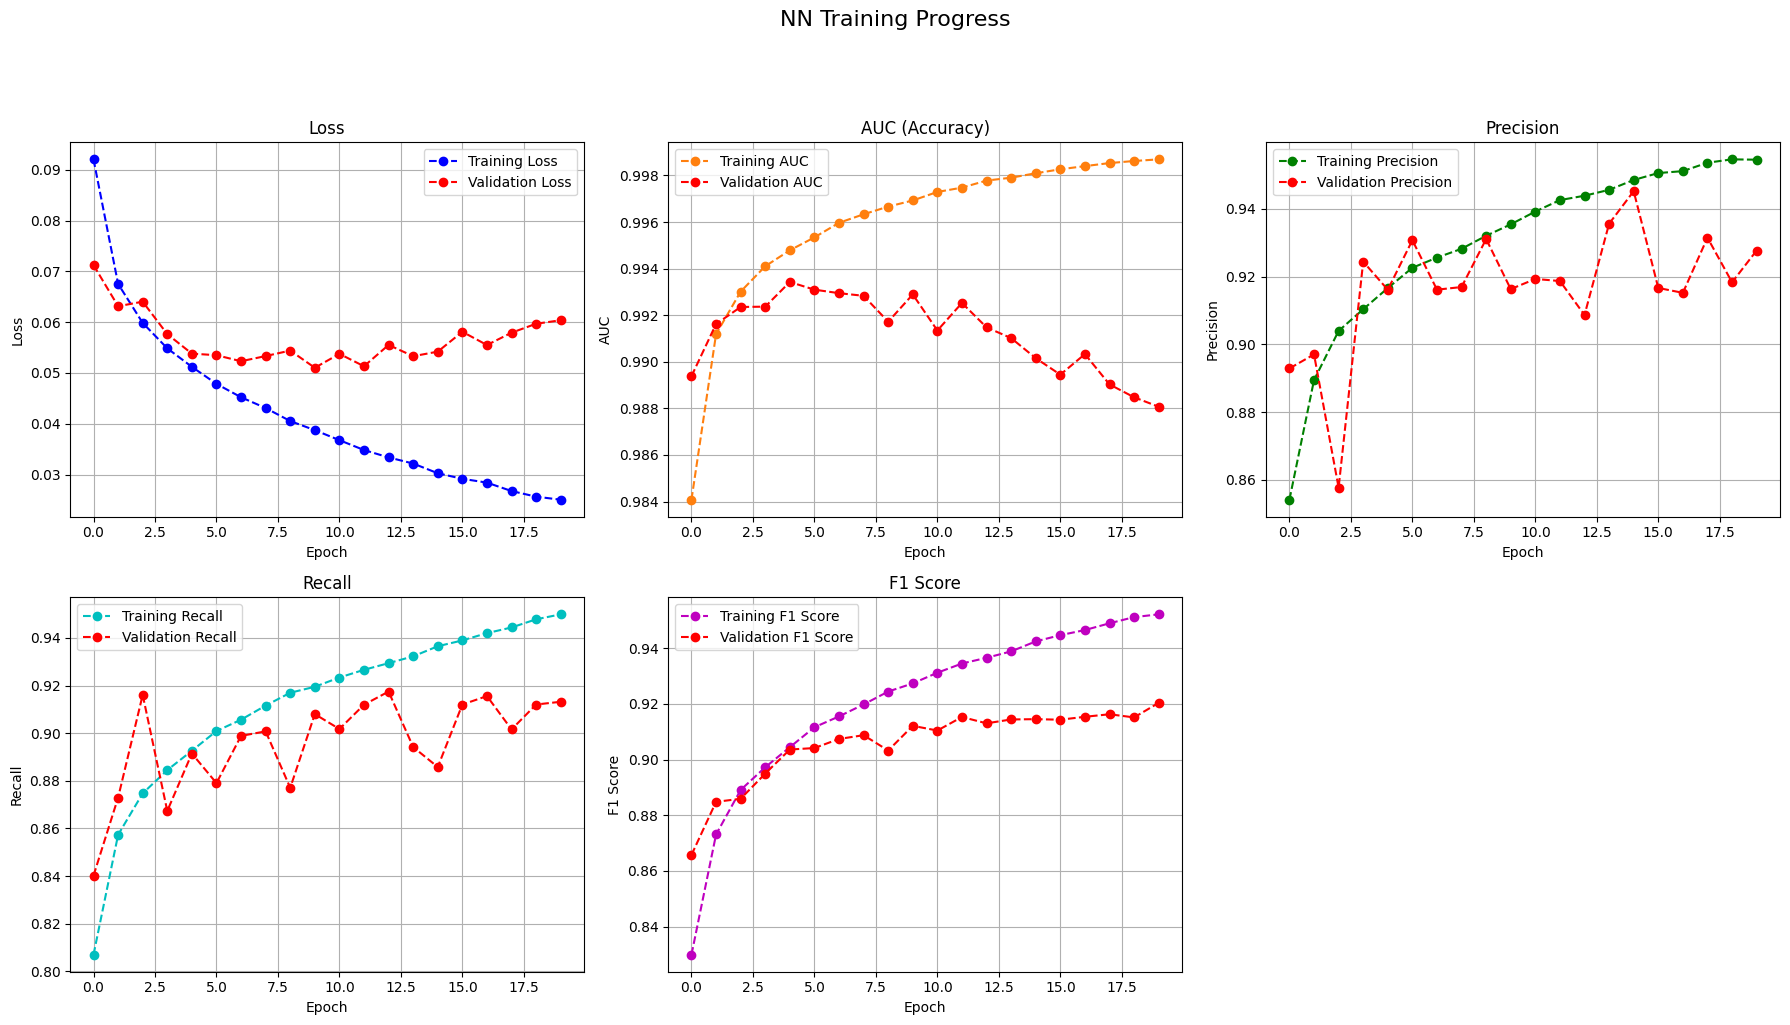

In [62]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_12" in history.history:
        return history.history[f"{metric_name}_12"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score
epoch_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


2025-04-14 13:44:29.353250: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 231557824 exceeds 10% of free system memory.


3440/3440 [==============================] - 5s 1ms/step - loss: 0.0510 - precision: 0.9163 - recall: 0.9080 - auc: 0.9929
Loss =  0.05102056264877319
Accuracy =  0.9162999391555786
3440/3440 [==============================] - 3s 756us/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.9886    0.9897    0.9891     97903
   Malicious     0.9163    0.9080    0.9121     12153

    accuracy                         0.9807    110056
   macro avg     0.9524    0.9489    0.9506    110056
weighted avg     0.9806    0.9807    0.9806    110056

False Positive Rate = 0.01029590513058844

Confusion Matrix:
[[96895  1008]
 [ 1118 11035]]


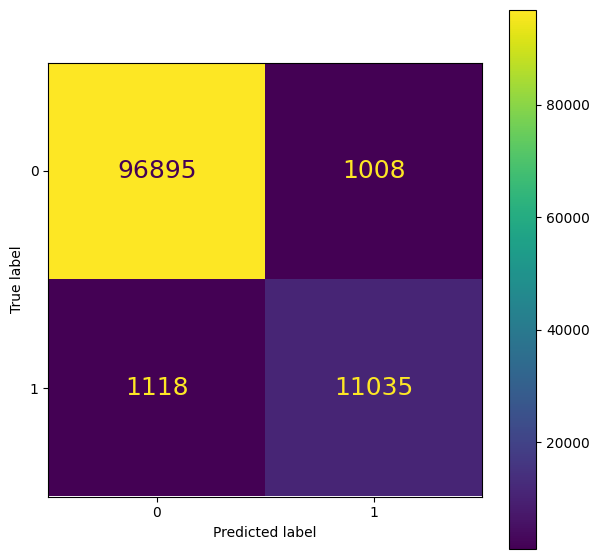

In [63]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

In [64]:
analyze_feature_importance = True

if analyze_feature_importance:
    
    import shap
    
    # Ensure that X_train and X_test are DataFrames with the correct column names
    # You can set the column names from the 'features' DataFrame like this:
    X_train.columns = features.columns
    X_test.columns = features.columns
    
    n_samples = 10000
    
    # Convert your training set to a NumPy format if it's not already
    background = X_train[:n_samples].to_numpy()
    
    # Use the generic SHAP Explainer interface
    explainer = shap.Explainer(model, background)
    
    # Generate SHAP values for the test set
    shap_values = explainer(X_test[:n_samples].to_numpy())
    
    # Plotting the summary plot for feature importance
    # Use the column names from the 'features' DataFrame as the feature names
    shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=30)


ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 515!